In [1]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

2024-10-21 07:48:37.675420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 07:48:37.693448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 07:48:37.698596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 07:48:37.759988: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "validation_data_path": f"{project_path}/data/validation",
    "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

paths_to_delete = [
    "unsorted_validation_data_path",
    "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32

encoding_dim = 256

Deleting /tf/data/validation/unsorted
Deleting /tf/data/validation/sorted


In [3]:
def download_dataset(force=False):
    # Construct the dataset path
    dataset_path = os.path.join(paths['train_data_path'], 'dataset_livrable_2.zip')

    # Check if the dataset is already downloaded
    if os.path.exists(dataset_path) and not force:
        print("Dataset is already downloaded.")
    else:
        print("Downloading dataset...")
        url = 'https://drive.google.com/uc?export=download&id=1WdcW_OqvRyuLiGx0FiZR0KmrqB9VYsLw'
        gdown.download(url, dataset_path, quiet=False)
    
    # Check if the dataset is already extracted
    if len(os.listdir(paths['train_data_path'])) == 2 and not force:
        print("Dataset is already extracted.")
    else:
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Extracting", unit="file") as pbar:
                for file in files:
                    zip_ref.extract(file, paths['train_data_path'])
                    pbar.update(1)
            print(f"Dataset extracted to {paths['train_data_path']}")
        
# Call the function
download_dataset()

Dataset is already downloaded.
Dataset is already extracted.


In [4]:
def check_images_in_dataset(dataset_path):
    # Get the paths of all image files (jpg, png, etc.)
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))  # You can specify extensions like '*.jpg' if necessary

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            # Read and decode the image to check if it is valid
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            # Catch specific TensorFlow error and remove bad files
            print(f"Found corrupt image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)
        except Exception as e:
            # General exception handler for other possible issues
            print(f"Error processing image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)

# Call the function to check the images in the train data path
#check_images_in_dataset(paths['train_data_path'])


In [5]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels=None,
    label_mode=None
)

Found 148 files.
Using 119 files for training.
Using 29 files for validation.


2024-10-21 07:48:39.892339: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (34)


Remarque sympa de notre ami le chat : 

Distribution du bruit : Si tu souhaites tester d'autres types de bruit, tu pourrais explorer différentes distributions (par exemple du bruit impulsionnel ou du bruit Poisson) en plus du bruit gaussien pour diversifier encore plus les perturbations appliquées aux images.

In [6]:
# Ajout de la couche de redimensionnement
rescale_layer = tf.keras.layers.Rescaling(1./255)


def add_gaussian_noise(images, min_noise=0.1, max_noise=0.4):
    batch_size = tf.shape(images)[0]
    noise_factor = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=min_noise, maxval=max_noise)
    noise = tf.random.normal(shape=tf.shape(images))
    noisy_images = images + noise_factor * noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)
    return noisy_images

# Création des datasets avec bruit
noisy_train_set = train_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


noisy_test_set = test_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

2024-10-21 07:48:40.492715: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-21 07:48:40.622998: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


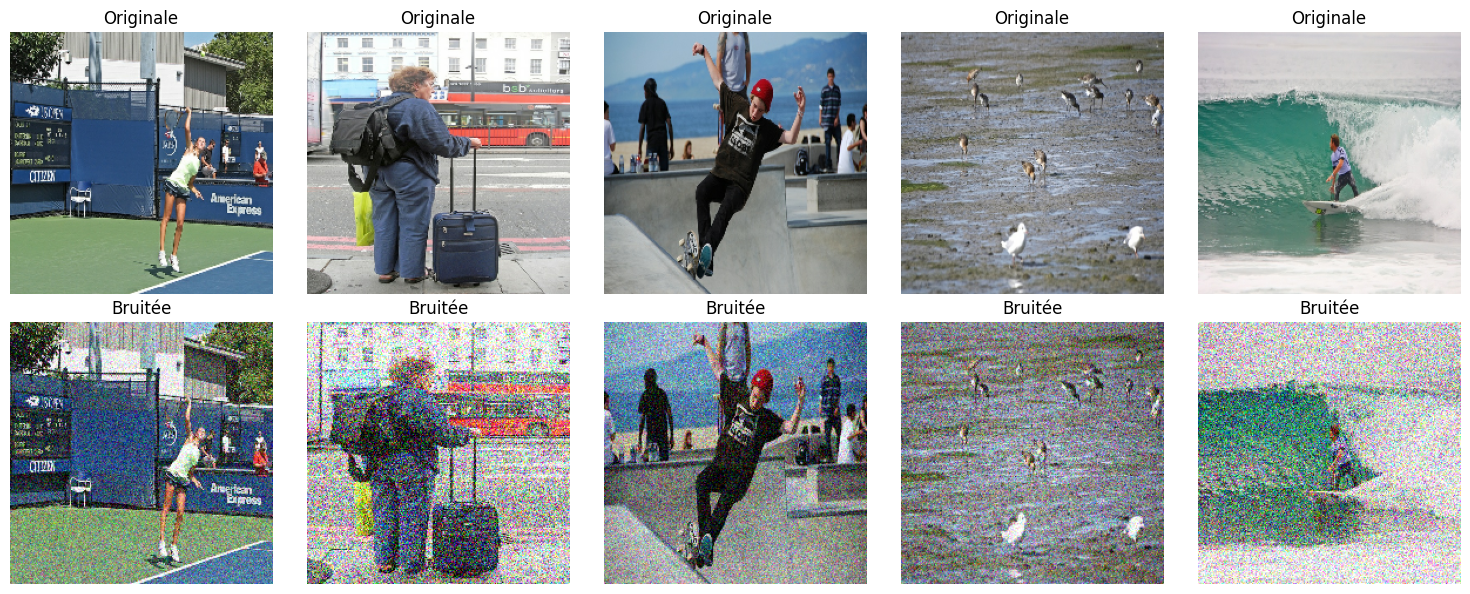

2024-10-21 07:48:41.861227: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Fonction pour afficher les images originales et bruitées
def display_noisy_train_images(noisy_dataset, num_images=5):
    plt.figure(figsize=(15, 6))

    for noisy_images, original_images in noisy_dataset.take(1):
        for i in range(num_images):
            # Image originale
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')

            # Image bruitée
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_noisy_train_images(noisy_train_set, num_images=5)
display_noisy_train_images(noisy_test_set, num_images=5)

In [8]:
def build_autoencoder(input_shape):
    input_img = tf.keras.layers.Input(shape=input_shape)
    
    # **Encoder**
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # **Decoder**
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # **Self-encoding model**
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

# **Model construction**
input_shape = (image_h, image_w, 3)
autoencoder = build_autoencoder(input_shape)


vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(image_h, image_w, 3))
vgg.trainable = False
feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv1').output)

@tf.function
def perceptual_loss(y_true, y_pred):
    y_true_features = feature_extractor(y_true)
    y_pred_features = feature_extractor(y_pred)
    loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))
    return loss

autoencoder.compile(optimizer='adam', loss=perceptual_loss)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# **Définition des callbacks**
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# **Entraînement du modèle**
history = autoencoder.fit(
    noisy_train_set,
    epochs=150,
    validation_data=noisy_test_set,
    callbacks=[early_stopping]
)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.0773 - val_loss: 0.0616
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0588 - val_loss: 0.0557
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 0.0479 - val_loss: 0.0376
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0383 - val_loss: 0.0379
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0377 - val_loss: 0.0351
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.0337 - val_loss: 0.0348
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.0319 - val_loss: 0.0309
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0298 - val_loss: 0.0295
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 0.0273 - val_loss: 0.0264
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - loss: 0.0248 - val_loss: 0.0260
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.0233 - val_loss: 0.0256
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - loss: 0.0235 - val_loss: 0.0259
E

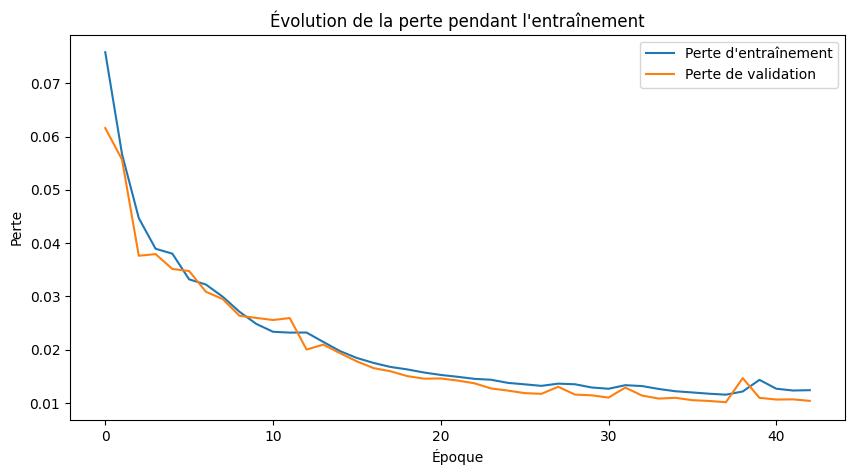

In [10]:
# **Tracer les courbes de perte**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

In [11]:
def display_denoised_images(model, dataset, num_images=5):
    plt.figure(figsize=(15, 8))

    for noisy_images, original_images in dataset.take(1):
        # Prédire les images débruitées
        denoised_images = model.predict(noisy_images)
        
        for i in range(num_images):
            # **Image bruitée**
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')
            
            # **Image débruitée**
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(denoised_images[i])
            plt.title('Débruitée')
            plt.axis('off')
            
            # **Image originale**
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# **Affichage des résultats**
display_denoised_images(autoencoder, noisy_test_set, num_images=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
